In [44]:
%pwd

'/Users/r/Documents/stud/ss24/finnpinn/src'

In [45]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
dir_paths = [p for p in Path("../data_out/finn_increasing_time").glob("finn_increasing_time_*") if p.is_dir()]
dir_paths

[PosixPath('../data_out/finn_increasing_time/finn_increasing_time_4'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_3'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_2'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_5'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_23'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_24'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_12'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_15'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_14'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_13'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_25'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_22'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_7'),
 PosixPath('../data_out/finn_increasing_time/finn_increasing_time_9')

In [47]:
df = {
    "retardation_file_paths": [],
    "num_time_steps": [],
    "num_epochs": [],
}
for p in dir_paths:
    all_ret_file_paths = sorted((p / "predicted_retardations").glob("retPred_*.npy"), key=lambda x: int(x.stem.split("_")[-1]))
    if not all_ret_file_paths:
        continue
    if np.any(np.isnan(np.load(all_ret_file_paths[-1]))):
        continue
    if np.any(np.load(all_ret_file_paths[-1]) > 10.0):
        continue
    if np.any(np.load(all_ret_file_paths[-1]) < 3.1):
        continue
    df["retardation_file_paths"].append(all_ret_file_paths[-1])
    df["num_time_steps"].append(int(p.name.split("_")[-1]))
    df["num_epochs"].append(int(all_ret_file_paths[-1].stem.split("_")[-1]))
df = pd.DataFrame(df).sort_values("num_time_steps").reset_index(drop=True)
df = df[df["num_time_steps"] < 13]
df = df[df["num_epochs"] >= 100].reset_index(drop=True)
df

,retardation_file_paths,num_time_steps,num_epochs
0,../data_out/finn_increasing_time/finn_increasi...,3,100
1,../data_out/finn_increasing_time/finn_increasi...,4,100
2,../data_out/finn_increasing_time/finn_increasi...,5,100
3,../data_out/finn_increasing_time/finn_increasi...,6,100
4,../data_out/finn_increasing_time/finn_increasi...,7,100
5,../data_out/finn_increasing_time/finn_increasi...,9,100
6,../data_out/finn_increasing_time/finn_increasi...,12,100


In [48]:
df2 = df.copy()
df2["ret"] = df["retardation_file_paths"].apply(lambda p: np.load(p).ravel())
df2 = df2.explode('ret').reset_index(drop=True)
df2["u"] = np.tile(np.arange(0, 100), len(df))
df2

,retardation_file_paths,num_time_steps,num_epochs,ret,u
0,../data_out/finn_increasing_time/finn_increasi...,3,100,5.006289,0
1,../data_out/finn_increasing_time/finn_increasi...,3,100,4.815995,1
2,../data_out/finn_increasing_time/finn_increasi...,3,100,4.654215,2
3,../data_out/finn_increasing_time/finn_increasi...,3,100,4.515988,3
4,../data_out/finn_increasing_time/finn_increasi...,3,100,4.397278,4
...,...,...,...,...,...
695,../data_out/finn_increasing_time/finn_increasi...,12,100,3.301182,95
696,../data_out/finn_increasing_time/finn_increasi...,12,100,3.300682,96
697,../data_out/finn_increasing_time/finn_increasi...,12,100,3.300196,97
698,../data_out/finn_increasing_time/finn_increasi...,12,100,3.299725,98


In [49]:
df2.dtypes

retardation_file_paths    object
num_time_steps             int64
num_epochs                 int64
ret                       object
u                          int64
dtype: object

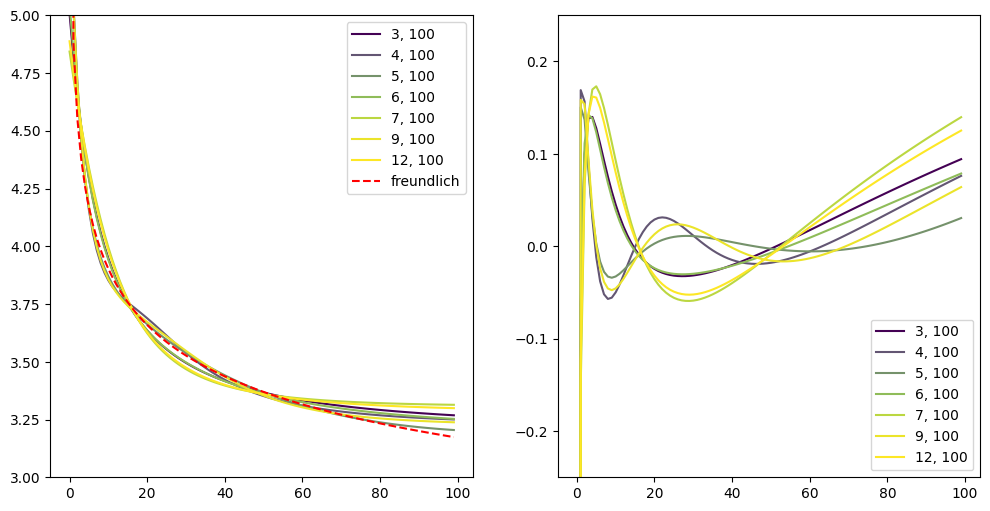

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ret_freundlich = np.load("../data_out/default_finn/retardation_freundlich.npy")

initial_colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
final_color = initial_colors[-1]

# highest_time_step_ret = np.load(df["retardation_file_paths"].iloc[-1])
highest_time_step_ret = ret_freundlich

for i, p in enumerate(df["retardation_file_paths"]):
    ret = np.load(p)
    mixed_color = initial_colors[i] * (1 - i / (len(df) - 1)) + final_color * (i / (len(df) - 1))
    ax1.plot(ret, label=f"{df['num_time_steps'][i]}, {df['num_epochs'][i]}", color=mixed_color)
    ax2.plot(ret-highest_time_step_ret, label=f"{df['num_time_steps'][i]}, {df['num_epochs'][i]}", color=mixed_color)
ax1.plot(ret_freundlich, "r--", label="freundlich")#, color=final_color)
ax1.set_ylim(3,5)
ax2.set_ylim(-.25,.25)
ax1.legend()
ax2.legend()
plt.show()

# FINN mit aufaddierten, gelernten Residuen

90%-Quantile (siehe `make_PI_datasets2.py`)

In [51]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

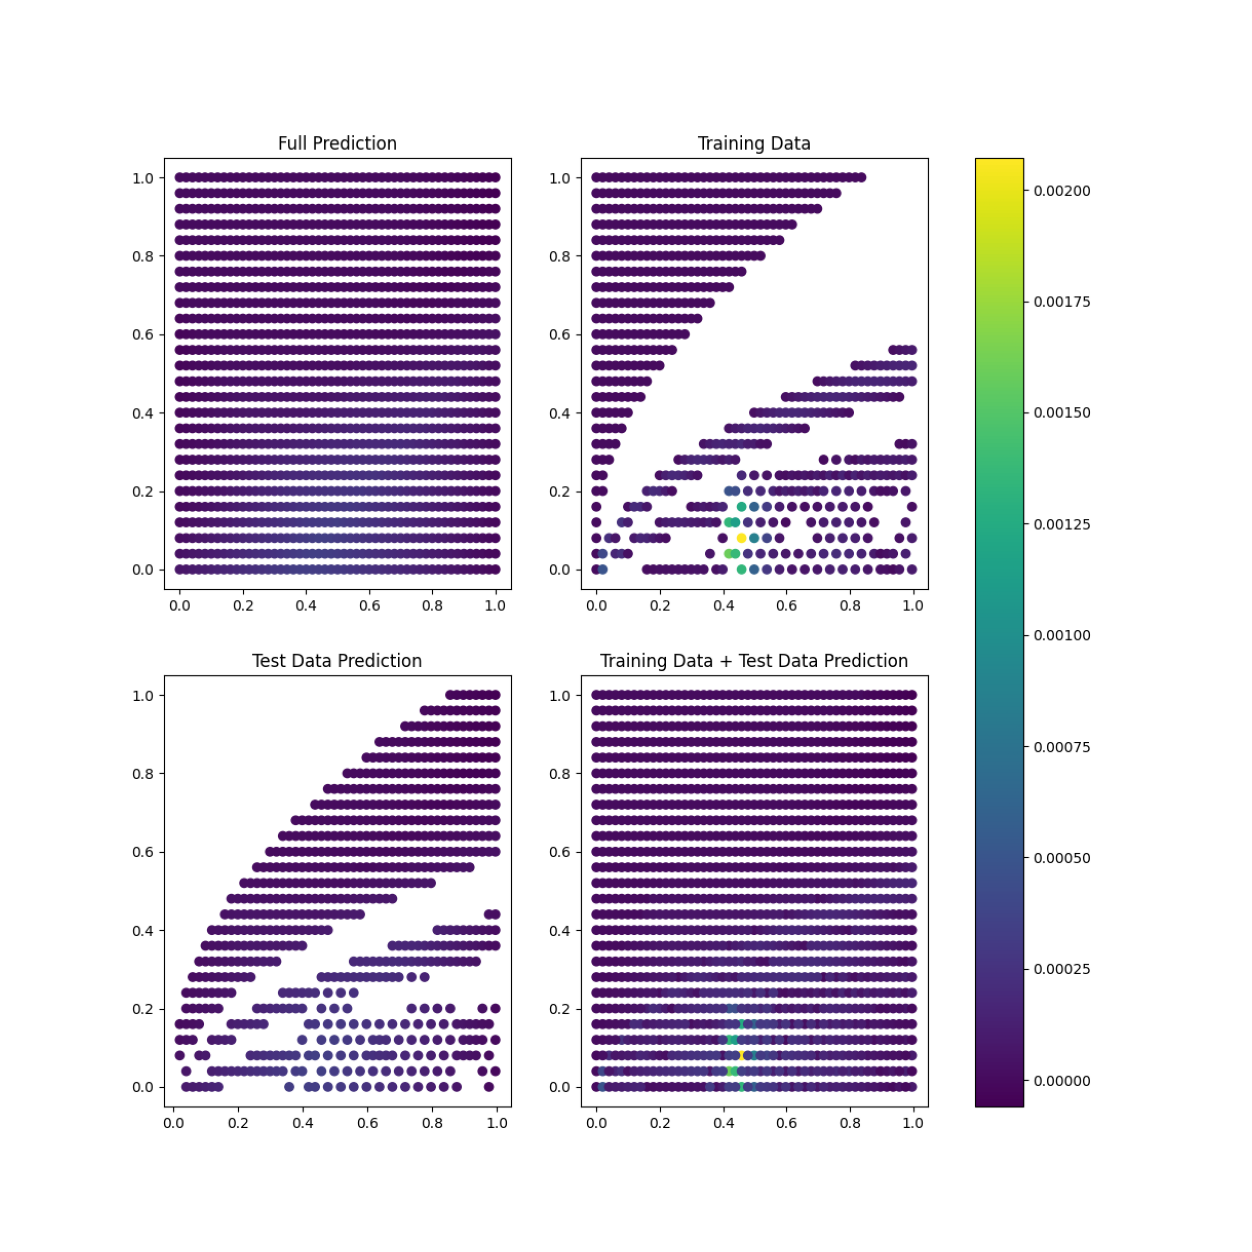

In [52]:
image_path = Path("../data_out/default_finn/residual_nets_output/predictions_pos_diss.png")
if image_path.exists():
    fig, ax = plt.subplots(figsize=(20, 16))
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Image not found at '{image_path}'")